In [145]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [146]:
PATH = r'/Users/teguhsatya/Desktop/36Cropped/JPEG'
retina = {}
ACCEPT = ('jpg', 'png', 'JPG', 'JPEG')
for files in os.listdir(PATH):
    print(f'reading {os.path.join(PATH, files)}')
    if files.split('.')[1] in ACCEPT:
        fname = files.split('.')[0]
        retina[fname] = cv2.imread(os.path.join(PATH, files))
        retina[fname] = cv2.cvtColor(retina[fname], cv2.COLOR_BGR2RGB)

reading /Users/teguhsatya/Desktop/36Cropped/JPEG/RET014OD.jpg
reading /Users/teguhsatya/Desktop/36Cropped/JPEG/RET030OS.jpg
reading /Users/teguhsatya/Desktop/36Cropped/JPEG/RET030OD.jpg
reading /Users/teguhsatya/Desktop/36Cropped/JPEG/RET015OS.jpg
reading /Users/teguhsatya/Desktop/36Cropped/JPEG/RET008OS.jpg
reading /Users/teguhsatya/Desktop/36Cropped/JPEG/RET004OS.jpg
reading /Users/teguhsatya/Desktop/36Cropped/JPEG/RET026OD.jpg
reading /Users/teguhsatya/Desktop/36Cropped/JPEG/RET026OS.jpg
reading /Users/teguhsatya/Desktop/36Cropped/JPEG/RET002OS.jpg
reading /Users/teguhsatya/Desktop/36Cropped/JPEG/RET002OD.jpg
reading /Users/teguhsatya/Desktop/36Cropped/JPEG/RET007OS.jpg
reading /Users/teguhsatya/Desktop/36Cropped/JPEG/RET007OD.jpg
reading /Users/teguhsatya/Desktop/36Cropped/JPEG/RET023OD.jpg
reading /Users/teguhsatya/Desktop/36Cropped/JPEG/RET023OS.jpg
reading /Users/teguhsatya/Desktop/36Cropped/JPEG/RET021OS.jpg
reading /Users/teguhsatya/Desktop/36Cropped/JPEG/RET021OD.jpg
reading 

In [147]:
print(retina.keys())

dict_keys(['RET014OD', 'RET030OS', 'RET030OD', 'RET015OS', 'RET008OS', 'RET004OS', 'RET026OD', 'RET026OS', 'RET002OS', 'RET002OD', 'RET007OS', 'RET007OD', 'RET023OD', 'RET023OS', 'RET021OS', 'RET021OD', 'RET025OS', 'RET025OD', 'RET018OS', 'RET018OD'])


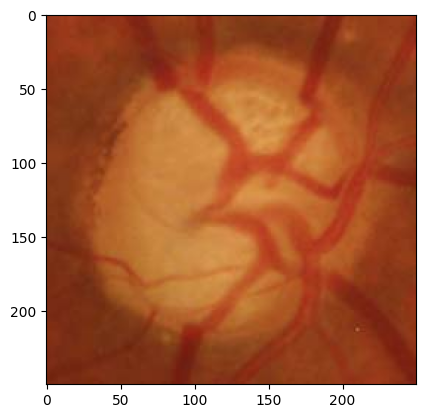

In [148]:
plt.imshow(retina['RET014OD'])

In [149]:
def display_all(imgs, subs=(10,10), use_gray=False):
    fig, axs = plt.subplots(subs[0], subs[1], figsize=(15, 18))
    k = 0
    for i in range(subs[0]):
        for j in range(subs[1]):
            axs[i, j].imshow(list(imgs.values())[k], 'gray' if use_gray else None)
            axs[i, j].set_title(list(imgs.keys())[k])
            # axs[i, j].axis('off')
            k+=1
            
def display_all_with(imgs, cc, subs=(10,10), use_gray=True):
    fig, axs = plt.subplots(subs[0], subs[1], figsize=(15, 18))
    k = 0
    for i in range(subs[0]):
        for j in range(subs[1]):
            axs[i, j].imshow(list(imgs.values())[k][:,:,cc], cmap='gray' if use_gray else None)
            axs[i, j].set_title(list(imgs.keys())[k])
            axs[i, j].axis('off')
            k+=1
            
def adjust_gamma(image, gamma=1.0):
    table = np.array([((i / 255.0) ** gamma) * 255
      for i in np.arange(0, 256)]).astype("uint8")

    return cv2.LUT(image, table)

def resize_all(imgs, factor=50):
    resized_imgs = {}
    for img in imgs:
        resized_imgs[img] = cv2.resize(imgs[img], 
                                       (int(imgs[img].shape[1]*factor/100), 
                                        int(imgs[img].shape[0]*factor/100)), 
                                       cv2.INTER_AREA)
    return resized_imgs

def remove_vessels(imgs):
    no_vsl = {}
    clahe = cv2.createCLAHE(1.5, (8,8))
    for img in imgs:
        g = imgs[img][:,:,1].copy()
        g_inv = 255-g
        clahed = clahe.apply(g_inv)
        g_gamma = adjust_gamma(clahed, 5)
        g_gauss = cv2.GaussianBlur(g_gamma, (15,15),0)
        ret, th = cv2.threshold(g_gauss.copy(),0,255,
                                cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        no_vsl[img] = cv2.inpaint(imgs[img].copy(), th, 3,cv2.INPAINT_TELEA)
    return no_vsl

In [150]:
wo_vsl = remove_vessels(retina)

In [155]:
def get_which_ellipse(contours):
    conts = np.array([contour.shape[0] for contour in contours])
    cont_idx = np.argmax(conts)
    ellipse = cv2.fitEllipse(contours[cont_idx])
    return ellipse

def get_circle(contours):
    conts = np.array([contour.shape[0] for contour in contours])
    cont_idx = np.argmax(conts)
    (x,y), radius = cv2.minEnclosingCircle(contours[cont_idx])
    return (x,y), radius


def extract_od(imgs):
    # tidak harus ada drawn_roi
    p = {}
    drawn_roi = {}
    ods = {}
    clahe = cv2.createCLAHE(3, (16,16))
    for img in imgs:
        red = imgs[img][:,:,0]
        gmcr = adjust_gamma(red, 2)
        gmclahe = clahe.apply(gmcr)
        gmcr_bl = cv2.GaussianBlur(gmclahe, (15,15), 0)
        # gmcr_bl = cv2.medianBlur(gmclahe, 11)
        erosion = cv2.erode(gmcr_bl.copy(), kernel=np.ones((20,20), np.uint8))
        dilation = cv2.dilate(erosion, kernel=np.ones((15,15), np.uint8))
        ret2, th2 = cv2.threshold(dilation,0,255,
                                  cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        cont, hcy = cv2.findContours(th2.copy(), 
                                     cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        # ellipse = get_which_ellipse(cont)
        (x,y),radius = get_circle(cont)
        center = (int(x),int(y))
        radius = int(radius)
        drawn_roi[img] = cv2.circle(imgs[img],center,radius,(0,255,0), 2)
        od = np.zeros_like(th2, dtype='uint8')
        od = cv2.circle(od, center, radius, (255, 255, 255), -1)
        ods[img] = od
        #display_all(ods, (4,5))
    return drawn_roi, ods

In [156]:
od_line, all_od = extract_od(wo_vsl)